# Personalized Melanoma Staging Model

The goal of this project is to create an easily understood and used tool for doctors to predict whether patients need a sentinel lymph node biopsy (SLNB). SLNB are an invasive procedure and currently doctors suggest it to patients if there is around a 10% chance for a positive biopsy. These odds are mostly based upon the depth of the melanoma, so I would like to use more data in order to create better predictions for the odds that patients need the biopsy. 

## The Data
I am using data from two sources: the National Cancer Database and the NIH's SEER Database. Currently, we are soley focusing on the NCDB's melanoma patients.

In [1]:
import pandas as pd

mela = pd.read_csv('Melanoma.csv')

In [2]:
print(len(mela.columns.values))
mela.columns.values

126


array(['PUF_CASE_ID', 'PUF_FACILITY_ID', 'FACILITY_TYPE_CD',
       'FACILITY_LOCATION_CD', 'AGE', 'SEX', 'RACE',
       'SPANISH_HISPANIC_ORIGIN', 'INSURANCE_STATUS', 'MED_INC_QUAR_00',
       'NO_HSD_QUAR_00', 'UR_CD_03', 'MED_INC_QUAR_12', 'NO_HSD_QUAR_12',
       'UR_CD_13', 'CROWFLY', 'CDCC_TOTAL_BEST', 'SEQUENCE_NUMBER',
       'CLASS_OF_CASE', 'YEAR_OF_DIAGNOSIS', 'PRIMARY_SITE', 'LATERALITY',
       'HISTOLOGY', 'BEHAVIOR', 'GRADE', 'DIAGNOSTIC_CONFIRMATION',
       'TUMOR_SIZE', 'REGIONAL_NODES_POSITIVE', 'REGIONAL_NODES_EXAMINED',
       'DX_STAGING_PROC_DAYS', 'RX_SUMM_DXSTG_PROC', 'TNM_CLIN_T',
       'TNM_CLIN_N', 'TNM_CLIN_M', 'TNM_CLIN_STAGE_GROUP', 'TNM_PATH_T',
       'TNM_PATH_N', 'TNM_PATH_M', 'TNM_PATH_STAGE_GROUP',
       'TNM_EDITION_NUMBER', 'ANALYTIC_STAGE_GROUP', 'CS_METS_AT_DX',
       'CS_METS_EVAL', 'CS_EXTENSION', 'CS_TUMOR_SIZEEXT_EVAL',
       'CS_METS_DX_BONE', 'CS_METS_DX_BRAIN', 'CS_METS_DX_LIVER',
       'CS_METS_DX_LUNG', 'LYMPH_VASCULAR_INVASION',
 

In [3]:
mela.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523492 entries, 0 to 523491
Columns: 126 entries, PUF_CASE_ID to PALLIATIVE_CARE_HOSP
dtypes: float64(64), int64(51), object(11)
memory usage: 503.2+ MB


As we can see, we have 523492 patients with 126 features (or attributes). Since it is a database, not all of these attributes would be known before a SLNB would be suggested and others of them would be irrelevant to the need for a biopsy. For example, <code>PUF_FACILITY_ID</code> (or the facility where these data were recorded) likely doesn't influence a patient's need for a biopsy. I will use the following subset of features below:

- <code>AGE</code>: The age of the patient
- <code>SEX</code>: The sex of the patient
- <code>RACE</code>: The race of the patient
- <code>SPANISH_HISPANIC_ORIGIN</code>: Indicates whether a patient is hispanic
- <code>CS_SITESPECIFIC_FACTOR_1</code>: The depth of the tumor. I rename this feature <code>DEPTH</code> to be more easily interpable
- <code>CS_SITESPECIFIC_FACTOR_2</code>: The formation of an ulcer on the skin. I rename this feature <code>ULCERATION</code> to be more easily interpable
- <code>CS_EXTENSION</code>: Indicates the extent of the spread of the melanoma.
- <code>CS_SITESPECIFIC_FACTOR_7</code>: Categories for the number of mitoses per square mm around a "hot spot". I rename this feature to <code>MITOSES</code> for interprability.
- <code>PRIMARY_SITE</code>: The main site for the melanoma. The options are:
    - <code>C44.0</code>: Skin of lips, NOS
    - <code>C44.1</code>: Eyelid
    - <code>C44.2</code>: External Ear
    - <code>C44.3</code>: Skin of other and unspecified parts of face
    - <code>C44.4</code>: Skin of scalp and neck
    - <code>C44.5</code>: Skin of the trunk
    - <code>C44.6</code>: Skin of upper limb and shoulder
    - <code>C44.7</code>: Skin of lower limb and hip
    - <code>C44.8</code>: Overlapping lesion of skin
    - <code>C44.9</code>: Skin, NOS
 
We are trying to calssify the patients into whether they had a positive lymph node biopsy or not. This is recorded in <code>TNM_PATH_N</code> or <code>REGIONAL_NODES_POSITIVE</code>.

In [378]:
#mela['TNM_PATH_N'].value_counts()

## Data Cleaning and Feature Combining

Some of the rows of the features are missing data. To start with, I will drop rows with missing data in order to have the best possible training data possible. This is a reasonable assumption currently because I have a large amount of training data, but I can work on creating a model including interpolation at a later point.

In [4]:
attribs = ['AGE', 'SEX', 'CS_SITESPECIFIC_FACTOR_1', 'CS_SITESPECIFIC_FACTOR_2',
           'CS_SITESPECIFIC_FACTOR_7', 'CS_EXTENSION', 'PRIMARY_SITE', 'CS_SITESPECIFIC_FACTOR_3']
#attribs = ['AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN', 'CS_SITESPECIFIC_FACTOR_1', 'CS_SITESPECIFIC_FACTOR_2',
#           'CS_SITESPECIFIC_FACTOR_7', 'CS_EXTENSION', 'PRIMARY_SITE', 'REGIONAL_NODES_POSITIVE']
#attribs = ['AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN', 'CS_SITESPECIFIC_FACTOR_1', 'CS_SITESPECIFIC_FACTOR_2',
#           'CS_SITESPECIFIC_FACTOR_7', 'CS_EXTENSION', 'PRIMARY_SITE', 'TNM_PATH_N']

#attribs = ['AGE', 'SEX', 'CS_SITESPECIFIC_FACTOR_1', 'CS_SITESPECIFIC_FACTOR_2',
#           'CS_SITESPECIFIC_FACTOR_7', 'CS_EXTENSION', 'PRIMARY_SITE', 'TNM_PATH_N']

In [5]:
data = mela[attribs].dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517967 entries, 0 to 523491
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   AGE                       517967 non-null  int64  
 1   SEX                       517967 non-null  int64  
 2   CS_SITESPECIFIC_FACTOR_1  517967 non-null  float64
 3   CS_SITESPECIFIC_FACTOR_2  517967 non-null  float64
 4   CS_SITESPECIFIC_FACTOR_7  517967 non-null  float64
 5   CS_EXTENSION              517967 non-null  float64
 6   PRIMARY_SITE              517967 non-null  object 
 7   CS_SITESPECIFIC_FACTOR_3  517967 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 35.6+ MB


In [381]:
#data['SPANISH_HISPANIC_ORIGIN'].value_counts() #9 means unknown if HISPANIC, 99 FOR RACE MEANS RACE UNKNOWN

In [6]:
data = data.rename(columns={'CS_SITESPECIFIC_FACTOR_1': "DEPTH", 'CS_SITESPECIFIC_FACTOR_2': 'ULCERATION',
       'CS_SITESPECIFIC_FACTOR_7': 'MITOSES', 'CS_SITESPECIFIC_FACTOR_3': 'CS_LYMPH_NODE_METS'})

In [7]:
#attribs = ['AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN', 'DEPTH', 'ULCERATION',
#           'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE', 'REGIONAL_NODES_POSITIVE']
attribs = ['AGE', 'SEX', 'DEPTH', 'ULCERATION',
        'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE', 'CS_LYMPH_NODE_METS']

#attribs = ['AGE', 'SEX', 'DEPTH', 'ULCERATION',
#           'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE', 'TNM_PATH_N']

### Dropping Missing Values
For most of our attributes, a missing value is coded as 999. We care remove these entries easily by using .dropna(). However, I need to do additional cleaning for each of our attributes.

In [8]:
new_df = data[(data != 999).all(1)]
new_df = new_df[new_df['DEPTH'] != 980]
#new_df = new_df[new_df['SPANISH_HISPANIC_ORIGIN'] != 9]
new_df = new_df[new_df['MITOSES'] <= 11]

#new_df.info()
new_df.describe()

,AGE,SEX,DEPTH,ULCERATION,MITOSES,CS_EXTENSION,CS_LYMPH_NODE_METS
count,137489.000000,137489.000000,137489.000000,137489.000000,137489.000000,137489.000000,137489.000000
mean,61.719898,1.423372,145.677320,1.848010,2.232491,248.404636,6.167664
std,15.865377,0.494095,168.689893,3.881366,3.120823,113.127404,9.879907
min,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,1.000000,40.000000,0.000000,0.000000,200.000000,5.000000
50%,63.000000,1.000000,85.000000,0.000000,1.000000,300.000000,5.000000
75%,74.000000,2.000000,180.000000,0.000000,3.000000,300.000000,5.000000
max,90.000000,2.000000,976.000000,10.000000,11.000000,950.000000,150.000000


### Combining Feature Values
For some of our features, there have been two coding schema. For example, `ULCERATION` = 1.0 and `ULCERATION` = 10.0 both correspond to the presence of ulceration. Below, we combine our features in order to better represent the data.

In [9]:
new_df['ULCERATION'] = new_df['ULCERATION'].replace(10.0, 1.0)
new_df['ULCERATION'].value_counts()

0.0    112080
1.0     25409
Name: ULCERATION, dtype: int64

The `CS_EXTENSION` attribute has a combination of features for the depth of the extension as well as the Clark Level. For now, I have removed anything that isn't about the Clark Level of the tumor.

In [10]:
new_df['CS_EXTENSION'].value_counts()
new_df['CS_EXTENSION'] = new_df['CS_EXTENSION'].replace([
    310, 315, 320, 330, 335, 340, 350, 355, 360, 370, 375, 380, 400, 800, 950],
    [999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999])
new_df = new_df[(new_df != 999).all(1)]
new_df['CS_EXTENSION'] = new_df['CS_EXTENSION']/100
new_df['CS_EXTENSION'].value_counts()

3.0    54609
1.0    27994
2.0    24766
5.0     6102
0.0     4337
Name: CS_EXTENSION, dtype: int64

In [387]:
#new_df['REGIONAL_NODES_POSITIVE'] = new_df['REGIONAL_NODES_POSITIVE'].replace(98, 0)
#new_df['REGIONAL_NODES_POSITIVE'].value_counts()
#new_df = new_df[(new_df['REGIONAL_NODES_POSITIVE'] != 99)]

#new_df['REGIONAL_NODES_POSITIVE'] = new_df['REGIONAL_NODES_POSITIVE'] > 0 
#new_df['REGIONAL_NODES_POSITIVE'].value_counts()

In [11]:
new_df['CS_LYMPH_NODE_METS'] = new_df['CS_LYMPH_NODE_METS'].replace([5, 10],[0, 1])
new_df = new_df[new_df['CS_LYMPH_NODE_METS'] <= 1.5]
new_df['CS_LYMPH_NODE_METS'].value_counts()


0.0    105400
1.0      8626
Name: CS_LYMPH_NODE_METS, dtype: int64

In [389]:
#new_df['TNM_PATH_N'].value_counts()
#new_df = new_df[new_df['TNM_PATH_N'] != '88']
#new_df = new_df[new_df['TNM_PATH_N'] != 'pX']

#new_df['TNM_PATH_N'].value_counts()
#new_df['TNM_PATH_N'] = new_df['TNM_PATH_N'].apply(lambda x: 0 if x == 'pX' else x)
#new_df['TNM_PATH_N'] = new_df['TNM_PATH_N'].apply(lambda x: 0 if x == 'p0' else 1)
#new_df['TNM_PATH_N'] = new_df['TNM_PATH_N'].apply(lambda x: x if x == 0 or x == 1 else 1)


In [390]:
#new_df['TNM_PATH_N'].value_counts()

For the `RACE` attribute, there are several demographics that we only have a single representative; for simplicity, we split these demographics into white, black, and other and hispanic or not hispanic.

In [12]:
import numpy as np
#new_df['RACE'].value_counts()
#a = np.array(new_df['RACE'].values.tolist())
#new_df['RACE'] = np.where(a > 2, 3, a).tolist()
#new_df['RACE'].value_counts()#new_df['RACE'] = new_df['RACE'].apply(lambda x: [y if y <= 1 else 2 for y in x])
##new_df['RACE']
#
#a = np.array(new_df['SPANISH_HISPANIC_ORIGIN'].values.tolist())
#new_df['SPANISH_HISPANIC_ORIGIN'] = np.where(a > 1, 1, a).tolist()
#new_df['SPANISH_HISPANIC_ORIGIN'].value_counts()

The other feature used is the `PRIMARY_SITE`, which codes where the melanoma is located. The features are fairly specific, so for now I coarse grain this into three categories: Head and neck, Trunk, or Extremity.

Current labels are

- `c440`: Skin of lip -> Head or Neck
- `c441`: Eyelid -> Head or Neck
- `c442`: External ear -> Head or Neck
- `c443`: Skin of other and unspecified parts of face -> Head or Neck
- `c444`: Skin of scalp and neck -> Head or Neck
- `c445`: Skin of trunk -> Trunk
- `c446`: Skin of upper limb and shoulder -> Extremity
- `c447`: Skin of lower limb and hip -> Extremity
- `c448`: Overlapping lesion of skin -> ?
- `c449`: Skin, NOS -> ?

In [392]:
#new_df['DEPTH_3'] = new_df['DEPTH'] ** 3

In [13]:
new_df['PRIMARY_SITE'].value_counts()
new_df['PRIMARY_SITE'] = new_df['PRIMARY_SITE'].replace([
    'C440', 'C441', 'C442', 'C443', 'C444', 'C445', 'C446', 'C447', 'C448', 'C449'],
    [0,0,0,0,0,1, 2,2,999,999])

new_df = new_df[(new_df != 999).all(1)]


In [14]:
#attribs = ['AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN', 'DEPTH', 'DEPTH_3', 'ULCERATION',
#           'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE']

attribs = ['AGE', 'SEX', 'DEPTH', 'ULCERATION',
            'MITOSES', 'CS_EXTENSION', 'PRIMARY_SITE']

X = new_df[attribs]
y = new_df['CS_LYMPH_NODE_METS']
#y = new_df['REGIONAL_NODES_POSITIVE']

import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)

## Encoding Attributes

We have a few <b>numerical attributes</b>
- AGE
- DEPTH
- MITOSES
- CS_EXTENSION


<b>Categorical Attributes</b>
- SEX
- RACE
- SPANISH_HISPANIC_ORIGIN
- ULCERATION
- PRIMARY_SITE

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names]
    
    
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X,y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["AGE","DEPTH", "CS_EXTENSION", "MITOSES"])),
    ('poly', PolynomialFeatures(degree=3)),
    ("imputer", SimpleImputer(strategy="median")),
     ])

from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(['SEX','ULCERATION', 'PRIMARY_SITE'])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False))
])

In [16]:
corr_matrix = new_df.corr()
corr_matrix["CS_LYMPH_NODE_METS"].sort_values(ascending=False)

CS_LYMPH_NODE_METS    1.000000
DEPTH                 0.253322
MITOSES               0.235096
CS_EXTENSION          0.211535
ULCERATION            0.191461
PRIMARY_SITE          0.031266
SEX                  -0.017389
AGE                  -0.070249
Name: CS_LYMPH_NODE_METS, dtype: float64

In [22]:
train_num = num_pipeline.fit_transform(X_train)
print(len(train_num))
print(len(y) - sum(y))

90816
104928.0


In [23]:
cat_pipeline.fit_transform(X_train);

### Pre-processing the data

Now, I want to take out the numerical attributes and the categorical attributes and format the data according to the pipeline above. In addition, I split the data again into a cross-validation set in order to better tune the model parameters.

In [24]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

x_train = preprocess_pipeline.fit_transform(X_train)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
x_train = sc.fit_transform(x_train)
x_cv, x_train = x_train[:10000, :], x_train[10000:,:]
y_cv, y_train = y_train[:10000], y_train[10000:]
print(X_train.head())
print(y_train)

        AGE  SEX  DEPTH  ULCERATION  MITOSES  CS_EXTENSION  PRIMARY_SITE
272276   60    2   46.0         0.0      0.0           1.0             1
32925    62    2   68.0         0.0      1.0           3.0             2
318766   56    2  180.0         1.0      2.0           3.0             2
167670   47    2   24.0         0.0      0.0           1.0             2
147181   58    1   65.0         0.0      0.0           2.0             1
416799    0.0
116889    0.0
127160    1.0
266797    0.0
171709    0.0
         ... 
147926    0.0
410205    0.0
111826    0.0
171287    0.0
427091    0.0
Name: CS_LYMPH_NODE_METS, Length: 80816, dtype: float64


# Methods for Estimating

Our baseline for estimating is to predict the majority class, i.e. that everyone doesn't need the SLNB. This gives us a point of comparison for the accuracy of our method: we must perform better than this in a meaningful way for our new model to be performing well.

In [25]:
class BaseLine(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1))

In [26]:
from sklearn.model_selection import cross_val_score
base_line_clf = BaseLine()
base_scores = cross_val_score(base_line_clf,x_train,y_train,cv=10,scoring="accuracy")
base_scores.mean()

0.9249158689942139

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

log_clf = LogisticRegression(solver="liblinear")
log_clf.fit(x_train,y_train)
log_scores = cross_val_score(log_clf, x_train,y_train,cv=10,scoring="accuracy")
y_pred = log_clf.predict(x_train)
log_score = accuracy_score(y_train,y_pred)
print(log_score)
log_scores.mean()

importance = log_clf.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train, y_pred))
#y_pred = y_pred == 2
#y_simple = y_train == 2
log_f1 = f1_score(y_train,y_pred)
log_recall = recall_score(y_train, y_pred)
log_precision = precision_score(y_train,y_pred)
print(f"The precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}")



0.9252004553553752
Feature: 0, Score: 0.00000
Feature: 1, Score: -1.23276
Feature: 2, Score: 7.13034
Feature: 3, Score: 4.08934
Feature: 4, Score: 4.82121
Feature: 5, Score: -0.41630
Feature: 6, Score: 2.08603
Feature: 7, Score: 0.96442
Feature: 8, Score: 0.84543
Feature: 9, Score: -4.64221
Feature: 10, Score: -0.51924
Feature: 11, Score: -4.11678
Feature: 12, Score: 0.65328
Feature: 13, Score: -1.04679
Feature: 14, Score: -4.89950
Feature: 15, Score: -0.94650
Feature: 16, Score: -0.00448
Feature: 17, Score: 0.27557
Feature: 18, Score: -0.42994
Feature: 19, Score: -1.54968
Feature: 20, Score: -1.06700
Feature: 21, Score: -1.04168
Feature: 22, Score: -0.34216
Feature: 23, Score: -0.82208
Feature: 24, Score: -0.23765
Feature: 25, Score: 0.04695
Feature: 26, Score: 0.67883
Feature: 27, Score: 2.32335
Feature: 28, Score: -1.40614
Feature: 29, Score: 1.04124
Feature: 30, Score: 0.29572
Feature: 31, Score: -2.04057
Feature: 32, Score: 0.99942
Feature: 33, Score: -0.01488
Feature: 34, Score: 

0.9241102889358703
0.9191
The precision is 0.43333333333333335, the recall is 0.016149068322981366, and the f1 score is 0.031137724550898204
[[9178   17]
 [ 792   13]]


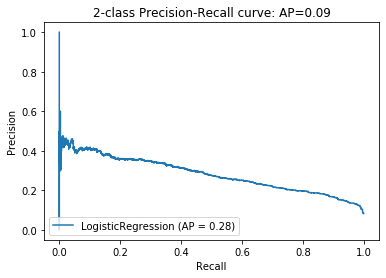

0.6331471585935188


In [69]:
x_test = preprocess_pipeline.transform(X_test) #running our train_set through the pipeline
x_test = sc.transform (x_test)
y_pred = log_clf.predict(x_test)
print(accuracy_score(y_pred,y_test))
#y_cv_test = y_cv == 2
#print(sum(y_cv_test))
#y_pred = y_pred == 2
#print(sum(y_pred == 2))
y_pred = log_clf.predict(x_cv)

log_score = accuracy_score(y_cv, y_pred)
print(log_score)
#print(y_test)
log_f1 = f1_score(y_cv,y_pred)
log_recall = recall_score(y_cv, y_pred)
log_precision = precision_score(y_cv,y_pred)
print(f"The precision is {log_precision}, the recall is {log_recall}, and the f1 score is {log_f1}")


y_proba = log_clf.predict_proba(x_cv)
from sklearn.metrics import precision_recall_curve
#precision, recall, thresholds = precision_recall_curve(y_cv, y_proba)

from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_cv, y_pred)

disp = plot_precision_recall_curve(log_clf, x_cv, y_cv)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

from sklearn import metrics
from sklearn.preprocessing import label_binarize
y = label_binarize(y_cv, classes = [0, 1])
fpr_logreg, tpr_logreg, thresholds = metrics.roc_curve(y, y_proba[:,1], pos_label=1)
misclassified = np.where(y_cv != y_pred)

print(confusion_matrix(y_cv, y_pred))
plt.show()
print(max(y_proba[:,1]))

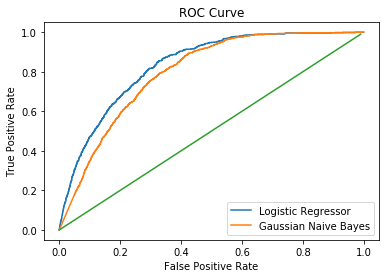

In [68]:
y_proba = gnb.predict_proba(x_cv)
fpr_gnb, tpr_gnb, thresholds = metrics.roc_curve(y, y_proba[:,1], pos_label=1)
plt.plot(fpr_logreg, tpr_logreg)
plt.plot(fpr_gnb, tpr_gnb)
x = np.arange(0,1,0.01)
plt.plot(x,x)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.legend(['Logistic Regressor','Gaussian Naive Bayes',''])
plt.show()

In [29]:
x_miss = x_cv[misclassified]
y_proba = log_clf.predict_proba(x_miss)

super_misclassified = np.where(y_proba[:][:,1] < 0.10)

x_features = x_miss[super_misclassified]

len(x_features)

#
#import seaborn as sns
##y_proba[:][:,0]
#sns.scatterplot(x=y_proba[:][:,0], y=y_proba[:][:,1])

#min(y_proba[:][:,1])
#min(y_proba[:][:,0])

231

In [30]:
print(confusion_matrix(y_cv, y_pred))


[[9178   17]
 [ 792   13]]


0.8392768758661651
The precision is 0.20077821011673153, the recall is 0.38266315095583386, and the f1 score is 0.2633698179549708
[[65505  9243]
 [ 3746  2322]]
0.8421
The precision is 0.22823033707865167, the recall is 0.40372670807453415, and the f1 score is 0.2916105877074921
[[8096 1099]
 [ 480  325]]
0.001343798041946182
0.3668528414064812
0.8421423537702607


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.09')

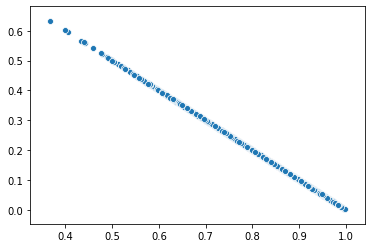

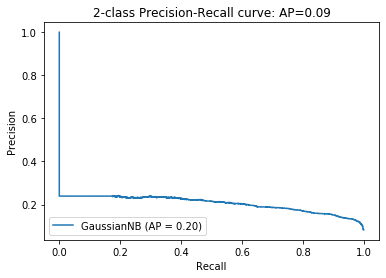

In [36]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_train)
gnb_score = accuracy_score(y_train, y_pred)
print(gnb_score)
#print(y_test)
gnb_f1 = f1_score(y_train,y_pred)
gnb_recall = recall_score(y_train, y_pred)
gnb_precision = precision_score(y_train,y_pred)
print(f"The precision is {gnb_precision}, the recall is {gnb_recall}, and the f1 score is {gnb_f1}")
print(confusion_matrix(y_train, y_pred))

y_pred = gnb.fit(x_train, y_train).predict(x_cv)
gnb_score = accuracy_score(y_cv, y_pred)
print(gnb_score)
#print(y_test)
gnb_f1 = f1_score(y_cv,y_pred)
gnb_recall = recall_score(y_cv, y_pred)
gnb_precision = precision_score(y_cv,y_pred)
print(f"The precision is {gnb_precision}, the recall is {gnb_recall}, and the f1 score is {gnb_f1}")
print(confusion_matrix(y_cv, y_pred))

misclassified = np.where(y_cv != y_pred)
x_miss = x_cv[misclassified]
y_proba = log_clf.predict_proba(x_miss)

import seaborn as sns
#y_proba[:][:,0]
sns.scatterplot(x=y_proba[:][:,0], y=y_proba[:][:,1])

print(min(y_proba[:][:,1]))
print(min(y_proba[:][:,0]))

y_pred = gnb.predict(x_test)
print(accuracy_score(y_pred,y_test))


disp = plot_precision_recall_curve(gnb, x_cv, y_cv)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))


0.9521381904573352
The precision is 0.9169825625473844, the recall is 0.39864864864864863, and the f1 score is 0.5557087066390994
[[74529   219]
 [ 3649  2419]]
0.8976
The precision is 0.21409921671018275, the recall is 0.10186335403726708, and the f1 score is 0.13804713804713806
[[8894  301]
 [ 723   82]]
0.001343798041946182
0.3668528414064812


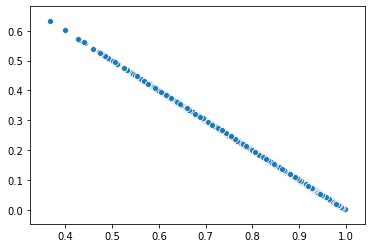

In [32]:
##Prone to Overfitting

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42, max_depth = 15)
tree.fit(x_train, y_train)

y_pred = tree.predict(x_train)
tree_score = accuracy_score(y_train, y_pred)
print(tree_score)
#print(y_test)
tree_f1 = f1_score(y_train,y_pred)
tree_recall = recall_score(y_train, y_pred)
tree_precision = precision_score(y_train,y_pred)
print(f"The precision is {tree_precision}, the recall is {tree_recall}, and the f1 score is {tree_f1}")
print(confusion_matrix(y_train, y_pred))

y_pred = tree.predict(x_cv)
tree_score = accuracy_score(y_cv, y_pred)
print(tree_score)
#print(y_test)
tree_f1 = f1_score(y_cv,y_pred)
tree_recall = recall_score(y_cv, y_pred)
tree_precision = precision_score(y_cv,y_pred)
print(f"The precision is {tree_precision}, the recall is {tree_recall}, and the f1 score is {tree_f1}")
print(confusion_matrix(y_cv, y_pred))

misclassified = np.where(y_cv != y_pred)
x_miss = x_cv[misclassified]
y_proba = log_clf.predict_proba(x_miss)

import seaborn as sns
#y_proba[:][:,0]
sns.scatterplot(x=y_proba[:][:,0], y=y_proba[:][:,1])

print(min(y_proba[:][:,1]))
print(min(y_proba[:][:,0]))

0.8976
The precision is 0.9153605015673981, the recall is 0.04812129202373105, and the f1 score is 0.0914357288241741 for depth 10
[[74721    27]
 [ 5776   292]]
0.9189
The precision is 0.3333333333333333, the recall is 0.007453416149068323, and the f1 score is 0.014580801944106925 for depth 10
[[9183   12]
 [ 799    6]]
0.001343798041946182
0.3668528414064812
0.8976
The precision is 0.9984785916105194, the recall is 0.7570863546473302, and the f1 score is 0.8611866154278751 for depth 20
[[74741     7]
 [ 1474  4594]]
0.9114
The precision is 0.28342245989304815, the recall is 0.06583850931677018, and the f1 score is 0.10685483870967744 for depth 20
[[9061  134]
 [ 752   53]]
0.001343798041946182
0.3668528414064812
0.8976
The precision is 0.9924772568229531, the recall is 0.9349044166117337, and the f1 score is 0.9628309572301427 for depth 30
[[74705    43]
 [  395  5673]]
0.9078
The precision is 0.27756653992395436, the recall is 0.0906832298136646, and the f1 score is 0.13670411985018

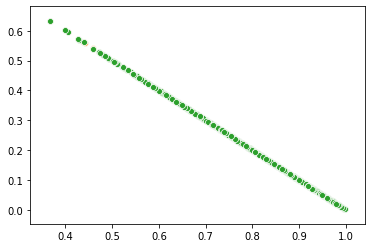

In [33]:
from sklearn.ensemble import RandomForestClassifier

depth = [10, 20, 30]

for d in depth:

    forest = RandomForestClassifier(max_depth = d,random_state=42)
    forest.fit(x_train,y_train)
    y_pred = forest.predict(x_train)
    forest_score = accuracy_score(y_train, y_pred)
    print(tree_score)
    #print(y_test)
    forest_f1 = f1_score(y_train,y_pred)
    forest_recall = recall_score(y_train, y_pred)
    forest_precision = precision_score(y_train,y_pred)
    print(f"The precision is {forest_precision}, the recall is {forest_recall}, and the f1 score is {forest_f1} for depth {d}")
    print(confusion_matrix(y_train, y_pred))
    
    y_pred = forest.predict(x_cv)
    forest_score = accuracy_score(y_cv, y_pred)
    print(forest_score)
    #print(y_test)
    forest_f1 = f1_score(y_cv,y_pred)
    forest_recall = recall_score(y_cv, y_pred)
    forest_precision = precision_score(y_cv,y_pred)
    print(f"The precision is {forest_precision}, the recall is {forest_recall}, and the f1 score is {forest_f1} for depth {d}")
    print(confusion_matrix(y_cv, y_pred))
    misclassified = np.where(y_cv != y_pred)
    x_miss = x_cv[misclassified]
    y_proba = log_clf.predict_proba(x_miss)

    import seaborn as sns
#y_proba[:][:,0]
    sns.scatterplot(x=y_proba[:][:,0], y=y_proba[:][:,1])

    print(min(y_proba[:][:,1]))
    print(min(y_proba[:][:,0]))



In [409]:
# import tensorflow as tf # Note that tf is the standard way to import tensorflow, much like pd is to pandas
# from tensorflow import keras

# # The code to build the neural network architecture. 

# # We will use the Keras sequential API to build the neural network one layer at a time
# NN = keras.models.Sequential()

# # Next add an input layer
# # '.Flatten' tells keras to reshape the data with this layer and not transform the inputs
# # We specified the input shape as [28,28] since that is the dimensions of our input arrays
# #print(len(x_train), len(x_train[0]))
# NN.add(keras.layers.Flatten(input_shape=(len(x_train[0]),)))

# # Make the hidden layers
# # The '.Dense' part just tells keras/tensorflow that this is just a regular densely connected layer.
# NN.add(keras.layers.Dense(10, activation='relu'))
# NN.add(keras.layers.Dense(5, activation='relu'))

# # Lastly add the output layer
# # Remember to specify the softmax activation function
# NN.add(keras.layers.Dense(2, activation='sigmoid'))

In [410]:
#NN.summary()

In [411]:
# weights, biases = NN.layers[1].get_weights()

In [412]:
# #from keras.optimizers import SGD
# opt = keras.optimizers.SGD(learning_rate=0.1)
#  NN.compile(loss = 'sparse_categorical_crossentropy', # This is explained much more below
#           optimizer = opt, # sgd stands for stochastic gradient descent
#           metrics = ['accuracy']) # These are other metrics you would like to calculate after each epoch

In [413]:
# history = NN.fit(x_train, y_train, epochs = 30,
#                  validation_data = (x_cv, y_cv))

In [414]:
# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline

# pd.DataFrame(history.history).plot(figsize=(8,5))
# plt.grid(True)
# plt.gca().set_ylim(0,1)
# plt.show();